In [1]:
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from astropy.coordinates import SkyCoord
from astropy.io import fits
from gammapy.irf import load_irf_dict_from_file
from scipy.stats import chi2, poisson

In [2]:
mrk421_coord = SkyCoord.from_name("Mrk 421")
es0229_coord = SkyCoord.from_name("1ES 0229+200")

# TOCOMPLETE: HBUs datas folder
mrk421_folder = "../data/mrk_421/"
es0229_folder = "../data/1ES_0229+200/"
# TOCOMPLETE: IRF file
irf_file = "../data/irfs/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits.gz"

**Choose here between Mrk 421 and 1ES 0229+200**

In [3]:
mrk421_choice = True

if mrk421_choice:
    blazar_coord = mrk421_coord
    data_folder = mrk421_folder
else:
    blazar_coord = es0229_coord
    data_folder = es0229_folder


blazar_l = blazar_coord.galactic.l.deg
blazar_b = blazar_coord.galactic.b.deg

hbus = []
for filename in os.listdir(data_folder):
    hbus.append(fits.open(data_folder + filename))

irf = load_irf_dict_from_file(irf_file)
aeff = irf["aeff"]

**Data collecting and overview**

In [4]:
# Source - background cake angle
src_angle = 0.2
# Extended emission angle
ext_angle = 0.25

data = {
    "src_energy": np.array([]),
    "ext_src_energy": np.array([]),
    "src_sep": np.array([]),
    "bkg_energy": np.array([]),
    "ext_bkg_energy": np.array([]),
    "all_coords_l": np.array([]),
    "all_coords_b": np.array([]),
    "all_energies": np.array([]),
    "all_sep": np.array([]),
    "offsets": np.array([]),
    "t_tot": np.array([]),
}

for hbu in hbus:
    data_raw = hbu["EVENTS"].data

    coord = SkyCoord(
        ra=data_raw["RA"] * u.deg, dec=data_raw["DEC"] * u.deg, frame="icrs"
    )

    pointing_coord = SkyCoord(
        ra=hbu[1].header["RA_PNT"] * u.deg,
        dec=hbu[1].header["DEC_PNT"] * u.deg,
        frame="icrs",
    )

    bkg_center = SkyCoord(
        l=2 * pointing_coord.galactic.l - blazar_coord.galactic.l,
        b=2 * pointing_coord.galactic.b - blazar_coord.galactic.b,
        frame="galactic",
    )

    src_pos_mask = coord.separation(blazar_coord).degree < src_angle
    bkg_pos_mask = coord.separation(bkg_center).degree < src_angle
    ext_src_pos_mask = coord.separation(blazar_coord).degree > ext_angle
    ext_bkg_pos_mask = coord.separation(bkg_center).degree > ext_angle

    t = data_raw["TIME"]
    t = np.sort(t)
    t_tot = t[-1] - t[0]

    data["src_energy"] = np.concatenate(
        [data["src_energy"], data_raw["ENERGY_TRUE"][src_pos_mask]]
    )

    data["ext_src_energy"] = np.concatenate(
        [
            data["ext_src_energy"],
            data_raw["ENERGY_TRUE"][src_pos_mask * ext_src_pos_mask],
        ]
    )

    data["src_sep"] = np.concatenate(
        [data["src_sep"], coord[src_pos_mask].separation(blazar_coord).degree]
    )

    data["all_coords_l"] = np.concatenate([data["all_coords_l"], coord.galactic.l.deg])
    data["all_coords_b"] = np.concatenate([data["all_coords_b"], coord.galactic.b.deg])
    data["all_energies"] = np.concatenate([data["all_energies"], data_raw["ENERGY"]])
    data["all_sep"] = np.concatenate(
        [data["all_sep"], coord.separation(blazar_coord).degree]
    )
    data["offsets"] = np.concatenate(
        [data["offsets"], [pointing_coord.separation(blazar_coord).degree]]
    )
    data["t_tot"] = np.concatenate([data["t_tot"], [t_tot]])

print(f"Near source events: {len(data['src_energy'])}")
print(f"Background events: {len(data['bkg_energy'])}")
print(f"Total events: {len(data['all_energies'])}")

Near source events: 98567
Background events: 0
Total events: 3335834


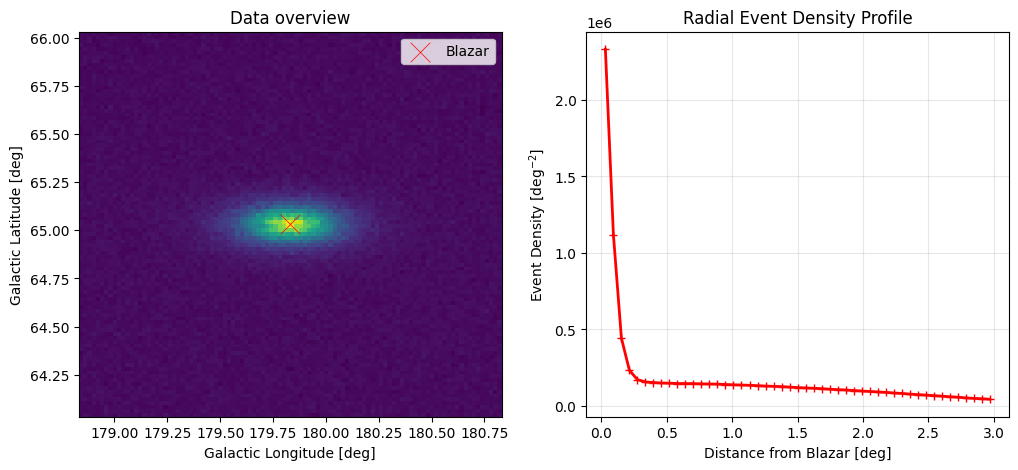

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Data overview
counts, xedges, yedges, im = ax1.hist2d(
    data["all_coords_l"],
    data["all_coords_b"],
    bins=100,
    range=[[blazar_l - 1, blazar_l + 1], [blazar_b - 1, blazar_b + 1]],
    cmap="viridis",
)
ax1.scatter(
    blazar_l, blazar_b, marker="x", color="red", s=200, linewidth=0.5, label="Blazar"
)
ax1.set_xlabel("Galactic Longitude [deg]")
ax1.set_ylabel("Galactic Latitude [deg]")
ax1.set_title("Data overview")
ax1.legend()

# Radial distribution
radial_bins = np.linspace(0, 3, 50)
radial_counts, bin_edges = np.histogram(data["all_sep"], bins=radial_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Normalize by area
areas = np.pi * (bin_edges[1:] ** 2 - bin_edges[:-1] ** 2)
density = radial_counts / areas
ax2.plot(bin_centers, density, marker="+", color="red", linewidth=2)
ax2.set_xlabel("Distance from Blazar [deg]")
ax2.set_ylabel(r"Event Density [deg$^{-2}$]")
ax2.set_title("Radial Event Density Profile")
ax2.grid(True, alpha=0.3)

plt.show()

**Background removal and source power approximation**

In [6]:
# For 1ES 0229+200 there is not a lot of data. It is better to set fewer energy bins.
energy_bins = np.logspace(-1, 1, 20)
bin_edges = energy_bins
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2

src_counts, _ = np.histogram(data["src_energy"], bins=energy_bins)
bkg_counts, _ = np.histogram(data["bkg_energy"], bins=energy_bins)
net_counts = src_counts - bkg_counts

# Considering a Poisson distribution.
src_errors = np.sqrt(src_counts)
bkg_errors = np.sqrt(bkg_counts)
net_errors = np.sqrt(src_counts + bkg_counts)

In [7]:
# Source SED approximation
blazar_offset = np.mean(data["offsets"])
dE = energy_bins[1:] - energy_bins[:-1]
exposure_time = np.sum(data["t_tot"])
effective_area = (
    aeff.evaluate(energy_true=bin_centers * u.TeV, offset=blazar_offset * u.deg)
    .to(u.cm**2)
    .value
)
sed_points = net_counts * (bin_centers**2) / (exposure_time * effective_area * dE)
sed_errors = net_errors * (bin_centers**2) / (exposure_time * effective_area * dE)

In [8]:
# Source SED upper bound approximation
confidence_level = 0.95
z_value = scipy.stats.norm.ppf(confidence_level)


# Calculate upper limits using chi-squared method
def calculate_upper_limit(n_obs, bkg, confidence_level=0.95):
    alpha = 1 - confidence_level
    if n_obs > 0:
        ul = 0.5 * chi2.ppf(confidence_level, 2 * (n_obs + 1)) - bkg
    else:
        ul = -np.log(alpha) - bkg
    return max(0, ul)


upper_limits = np.array(
    [
        calculate_upper_limit(src_counts[i], bkg_counts[i], 0.95)
        for i in range(len(src_counts))
    ]
)
sed_upper_limits = (
    upper_limits * (bin_centers**2) / (exposure_time * effective_area * dE)
)

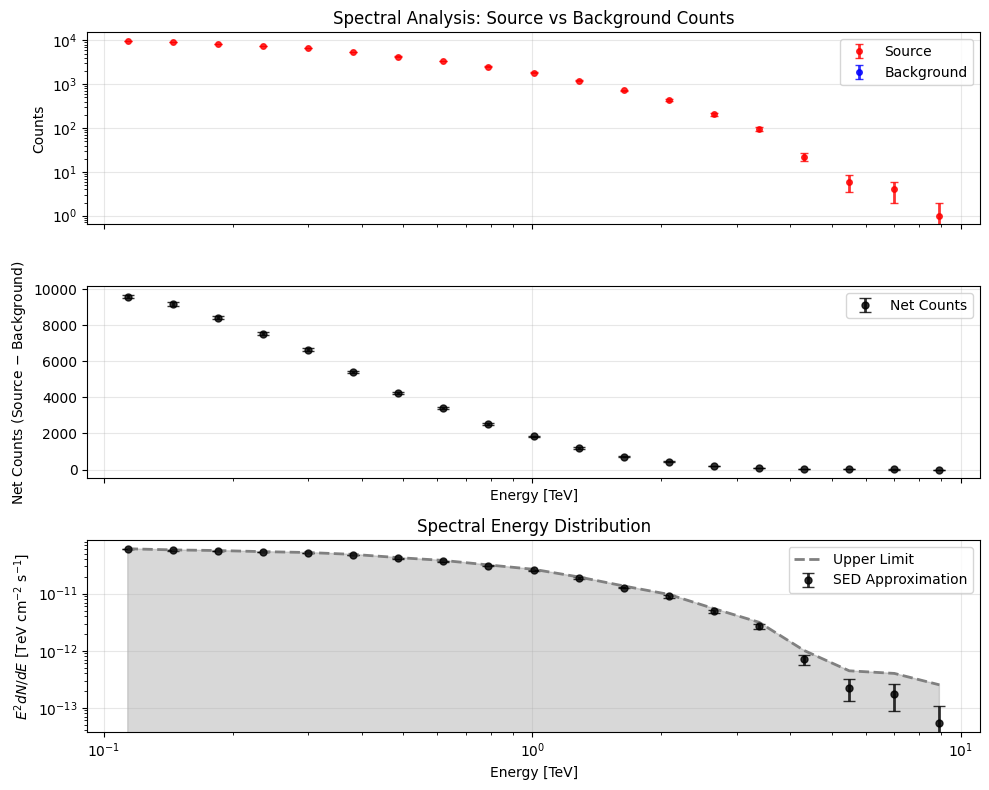

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Displaying source & background counts
ax1.errorbar(
    bin_centers,
    src_counts,
    yerr=src_errors,
    fmt="o",
    color="red",
    markersize=4,
    linewidth=2,
    label="Source",
    capsize=3,
    alpha=0.8,
)
ax1.errorbar(
    bin_centers,
    bkg_counts,
    yerr=bkg_errors,
    fmt="o",
    color="blue",
    markersize=4,
    linewidth=2,
    label="Background",
    capsize=3,
    alpha=0.8,
)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Counts")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title("Spectral Analysis: Source vs Background Counts")

# Displaying (source - background) counts
ax2.errorbar(
    bin_centers,
    net_counts,
    yerr=net_errors,
    fmt="o",
    color="black",
    markersize=5,
    linewidth=2,
    label="Net Counts",
    capsize=4,
    alpha=0.8,
)
ax2.set_xscale("log")
ax2.set_xlabel("Energy [TeV]")
ax2.set_ylabel("Net Counts (Source $-$ Background)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Displaying SED
ax3.errorbar(
    bin_centers,
    sed_points,
    yerr=sed_errors,
    fmt="o",
    color="black",
    markersize=5,
    linewidth=2,
    label="SED Approximation",
    capsize=4,
    alpha=0.8,
)
ax3.plot(
    bin_centers,
    sed_upper_limits,
    color="gray",
    linewidth=2,
    linestyle="--",
    label="Upper Limit",
)
ax3.fill_between(bin_centers, 0, sed_upper_limits, color="gray", alpha=0.3)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("Energy [TeV]")
ax3.set_ylabel(r"$E^2 dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_title("Spectral Energy Distribution")

plt.tight_layout()
plt.show()

**Statistical tests for source detection**

In [10]:
# Statistical tests for source detection
t_stat, p_value = scipy.stats.ttest_1samp(net_counts, 0)

total_background = np.sum(bkg_counts)
total_observed = np.sum(src_counts)
p_value_poisson = 1 - poisson.cdf(total_observed - 1, total_background)

print(f"T-test: t = {t_stat:.3f}, p = {p_value:.3f}")
print(f"Poisson test: p = {p_value_poisson:.3e}")

T-test: t = 4.037, p = 0.001
Poisson test: p = 0.000e+00


**Angular SED**

In [11]:
ANGLE_BINS = np.linspace(0.0, 0.12, 30)
ENERGY_RANGES = [(0.5, 1.5), (1.5, 4.0)]

angle_bin_centers = (ANGLE_BINS[1:] + ANGLE_BINS[:-1]) / 2
exposure_time = np.sum(data["t_tot"])
blazar_offset = np.mean(data["offsets"])


def calculate_angular_sed_for_range(E_min, E_max):
    dE = E_max - E_min
    E_mean = (E_max + E_min) / 2

    energy_mask = (data["all_energies"] > E_min) & (data["all_energies"] < E_max)

    counts_per_bin = []

    for i in range(len(ANGLE_BINS) - 1):
        angle_mask = (data["all_sep"] ** 2 >= ANGLE_BINS[i]) & (
            data["all_sep"] ** 2 < ANGLE_BINS[i + 1]
        )
        counts = np.sum(angle_mask & energy_mask)
        counts_per_bin.append(counts)

    counts_per_bin = np.array(counts_per_bin)

    effective_areas = np.array(
        [
            aeff.evaluate(energy_true=E_mean * u.TeV, offset=np.sqrt(angle_sq) * u.deg)
            .to(u.cm**2)
            .value
            for angle_sq in angle_bin_centers
        ]
    )

    sed_values = counts_per_bin * (E_mean**2) / (exposure_time * effective_areas * dE)
    sed_errors = sed_values / np.sqrt(np.maximum(counts_per_bin, 1))

    return sed_values, sed_errors

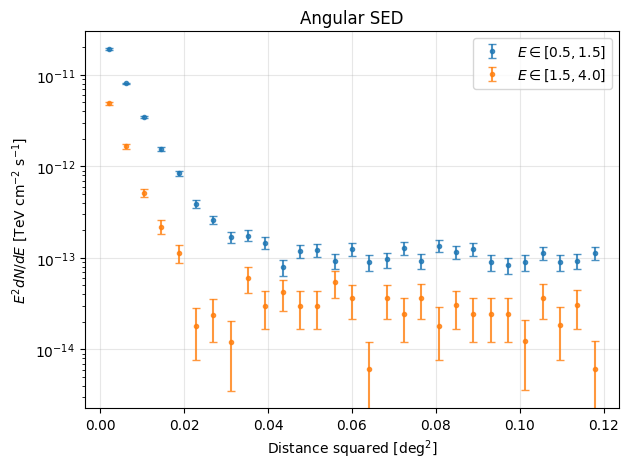

In [13]:
for E_min, E_max in ENERGY_RANGES:
    sed_values, sed_errors = calculate_angular_sed_for_range(E_min, E_max)

    plt.errorbar(
        angle_bin_centers,
        sed_values,
        yerr=sed_errors,
        fmt=".",
        markersize=6,
        linewidth=1.5,
        capsize=3,
        alpha=0.8,
        label=rf"$E\in[{E_min}, {E_max}]$",
    )

plt.yscale("log")
plt.xlabel(r"Distance squared [deg$^2$]")
plt.ylabel(r"$E^2 dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
plt.title("Angular SED")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()